<a href="https://colab.research.google.com/github/astrfo/RS_init/blob/main/RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RS 実装

[満足化を通じた最適な自律的探索] https://www.jstage.jst.go.jp/article/pjsai/JSAI2018/0/JSAI2018_1Z304/_article/-char/ja/

[論文要約] https://colab.research.google.com/drive/199SxVBGDdkuzSzU9pjVP9BfMPzaypLfj#scrollTo=UUSaBpguVsBB




In [204]:
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [205]:
class Environment(object):

    def __init__(self, K):
        self._K = K
        self.prob = np.array([np.random.rand() for _ in range(K)])   #一様分布からサンプリング
        print(f'{self.prob}')

    def play(self, arm):
        if self.prob[arm] > random.random():
            return 1
        else:
            return 0

In [206]:
class Agent(object):

    def __init__(self, K):
        self._K = K
        self._alpha = None
        self._V = None
        self._n = None
        self._N = None
        self.RS = None
        self.aleph = 1.0        #必ず非満足状態になるように

    def initialize(self):
        self._V = np.array([0.5] * self._K)     #Vの初期値は0.5
        self._n = np.array([1e-8] * self._K)      #RS式でゼロ除算を防ぐため, sys.float_info.minでエラーになる可能性がある
        self._N = 0     #総試行回数
        self.RS = np.zeros(self._K)     #?. RSの初期値はゼロ？？
        # self._alpha = np.zeros(self._K)     #?. alphaは各腕n(a_i)によって分けるべきなのか？ a.多分そんなことしなくていい。

    def update(self, arm, reward):
        # print(f'alpha: {self._alpha}')
        self._n[arm] += 1       #?. n(a_i)+=1の処理を先に行わないとハズレの場合、初期値V(a_i)=0.5がゼロになるので良くないのでは？
        self._N += 1
        self._alpha = 1 / (1 + self._n[arm])
        self._V[arm] = (1 - self._alpha) * self._V[arm] + self._alpha * reward

        self.RS[arm] = (self._n[arm] / self._N) * (self._V[arm] - self.aleph)     #RS評価値の更新(これは後で分ける？)
        # print(f'alpha: {self._alpha}')
        # print(f'V: {self._V}')
        # print(f'n: {self._n}')
        # print(f'N: {self._N}')
        # print(f'RS: {self.RS}')

    def update_aleph(self):
        #2本腕を想定
        max_V = np.amax(self._V)
        # print(f'V: {self._V}')
        # print(f'maxV: {max_V}')
        mI = random.choice(np.where(self._V == max_V)[0])       #複数あった場合エラー吐く
        if mI == 0: nmI = 1     #このコードは直せ
        else: nmI = 0
        # nmI = random.choice(np.where(self._V != max_V)[0])
        upper = 1 - (self._V[nmI]/self._V[mI]) * (self._n[nmI]/self._n[mI])     #腕の確率が小さいと V(a_G) = V(a_j) = 0 でエラーになる可能性がある(一度も当たらない(かなりレアケース))
        under = (1 - self._n[nmI]/self._n[mI])
        self.aleph = max_V * upper / under      #step数が小さいと upper = under になる可能性がある
        # print(f'n: {self._n}')
        # print(f'V: {self._V}')
        # print(f'upper: {upper}, under: {under}')
        # print(f'aleph: {self.aleph}')

    def select_arm(self):
        maxRS = np.amax(self.RS)
        maxIndex = np.where(self.RS == maxRS)[0]
        # print(f'RS: {self.RS}')
        # print(f'maxRS: {maxRS}')
        # print(f'maxIndex: {maxIndex}')
        # print(f'random.maxIndex: {random.choice(maxIndex)}')
        return random.choice(maxIndex)

In [207]:
class Simulator(object):
    
    def __init__(self, trial, step, K):
        self._agent = Agent(K)
        self._env = None
        self._prob = None
        self._trial = trial
        self._step = step
        self._regret = np.zeros((trial, step))

    def run(self):
        for t in range(self._trial):
            print(f'{t}:')
            self._env = Environment(K)
            self._prob = self._env.prob
            self._agent.initialize()
            for s in range(self._step):
                arm = self._agent.select_arm()
                reward = self._env.play(arm)
                self._agent.update(arm, reward)
                # print(f'arm: {arm}, reward: {reward}')
                self.calc_regret(t, s, arm)
                # print()
            print(f'{self._agent.RS}')
            self._agent.update_aleph()
            print()
        self.print_regret()

    def calc_regret(self, t, s, arm):
        self._regret[t][s] += np.amax(self._prob) - self._prob[arm]
        if s != 0: self._regret[t][s] += self._regret[t][s-1]
        # print('regret:')
        # print(f'{self._regret}')

    def print_regret(self):
        plt.plot(np.arange(self._step), np.mean(self._regret, axis=0), label='RS', linestyle='dashed')
        plt.xlabel('steps')
        plt.ylabel('regret')
        plt.legend()
        plt.show()

0:
[0.69690573 0.69490732]
[-0.75000001 -0.3031965 ]

1:
[0.86942176 0.64578328]
[ 0.17071072 -0.00944739]

2:
[0.78392636 0.0967421 ]
[-0.1055116  -0.31305861]

3:
[0.46921593 0.30138303]
[-0.20643288 -0.14278367]

4:
[0.67702198 0.12898092]
[-0.03025979 -0.42679009]

5:
[0.66591199 0.46925195]
[-0.0073899 -0.3968973]

6:
[0.10713797 0.65757566]
[-0.05567337 -0.00474564]

7:
[0.81886054 0.69741605]
[ 0.19223174 -0.09651896]

8:
[0.62774714 0.1491443 ]
[-0.19338608 -0.28953983]

9:
[0.98947892 0.34381503]
[ 0.35307348 -0.07338627]

10:
[0.81467503 0.62299243]
[-0.16283097 -0.37224699]

11:
[0.0302078  0.48500014]
[-0.37140745 -0.34175948]

12:
[0.07108654 0.48871394]
[-0.24324174  0.003255  ]

13:
[0.14534512 0.23257164]
[-0.15170824 -0.16487568]

14:
[0.09383816 0.38430031]
[-0.32842717 -0.17110547]

15:
[0.17627884 0.23459494]
[-0.17065115 -0.13186559]

16:
[0.98826469 0.15822618]
[ 0.74493311 -0.07039086]

17:
[0.58347197 0.45224513]
[-0.28247465 -0.1820638 ]

18:
[0.58988275 0.4970

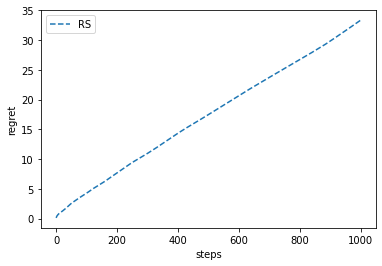

In [214]:
trial = 100
step = 1000      #step数が少ないと n(a_G)=n(a_j) になりaleph更新式がゼロ除算を行ってエラーになる可能性がある
K = 2
sim = Simulator(trial, step, K)
sim.run()